In [92]:
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import random
import os
import numpy as np
import torch
import sys
from scipy import stats
import matplotlib.pyplot as plt

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [ ]:
sys.path.append('../utils')

In [18]:
from training_nn import training_rnn
from evaluation import plot_loss, evaluate_model_rnn
from process_data import get_desc, get_data
from models import RNNembed
from dataset import Abencode2

In [19]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [20]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)


Convert string to float sequence features

In [21]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [22]:
train_target, valid_target, target_test, back_train = get_data(train, test, samples = 200, target_ab='REGN33')

In [23]:
train_target

,junction_aa,Label,Distance,Antibody,repr
104975,CCRGFNCYVPLMNYGFWRTSGVGY,0,9,REGN33,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
145322,EIRGFNCYCPLYRYGFWPTNGRNW,0,10,REGN33,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
128872,KNTGFNCYEPLSTYGFWRTVGLGY,0,8,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
54774,KNEGFNCYGPIVQYGFWTTSGRDY,1,9,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
49358,KNTGFNCYPPIATYGFWPTGGIGW,1,9,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
117752,KNKQFNCYGPIMAYGFYPTVGENW,1,11,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
49438,KNTGFNCYAPLVHYGFYPTVGNDW,1,9,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
88584,GNAGFNCYWPIDAYGFHPTVGMSF,0,11,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
119550,KNRQFNCYLPIVNYGFYPTVGLGW,0,10,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Convert dataframes to torch dataloader

In [24]:
def prepare_dataloader(df, dataset_torch, batch_size=5, shuffle=True):
    dataset = dataset_torch(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [25]:
validloader = prepare_dataloader(valid_target, Abencode2, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, Abencode2, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, Abencode2, shuffle=False, batch_size=50)
trainloader_back = prepare_dataloader(back_train, Abencode2, shuffle=True, batch_size=10)

Train base model using only REGN33 data 

In [51]:
model = RNNembed().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


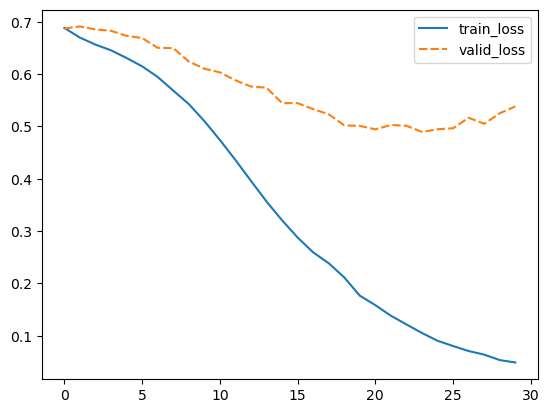

In [52]:
plot_loss(loss_train_hist, loss_valid_hist)

In [53]:
evaluate_model_rnn(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.762821,0.682356,0.812712,0.741851,0.855227


Pre-Training model using data of background antibodies (not including antibody of interest)

In [29]:
model = RNNembed().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 20
loss_train_hist, loss_valid_hist = training_rnn(model, criterion, optimizer, num_epochs, trainloader_back, validloader)

100%|██████████| 20/20 [23:39<00:00, 70.96s/it]


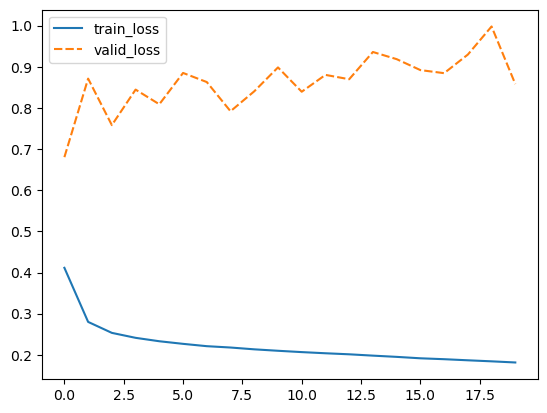

In [30]:
plot_loss(loss_train_hist, loss_valid_hist)

In [31]:
evaluate_model_rnn(testloader, model)  

,accuracy,recall,precision,f1_scor,auc
0,0.663248,0.612952,0.680933,0.645156,0.72292


Save  pretrained model

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [32]:
def copy_model(model, *args):
    model_copy = type(model)(*args)
    model_copy.load_state_dict(model.state_dict())
    return model_copy.to(device)

Copy model with the same weights

In [34]:
model_copy = copy_model(model)

Freeze weights except of linear1 and linear2 layers

In [36]:
def freeze_weights(model, name_layers=['linear1', 'linear2']):
    for name, param in model.named_parameters():
        if not any([layer in name for layer in name_layers]):
            param.requires_grad = False
    return model
    

In [37]:
model_copy = freeze_weights(model_copy)

Fine-tune the model updating the weights only of linear layers

In [38]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_copy.parameters(), lr=1e-3)
num_epochs = 10
loss_train_hist, loss_valid_hist = training_rnn(model_copy, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [39]:
evaluate_model_rnn(testloader, model_copy)

,accuracy,recall,precision,f1_scor,auc
0,0.837988,0.798531,0.866602,0.831175,0.921381


In [41]:
target_df = train.loc[train['Antibody'] == 'REGN33']

Extract  40 different samples of RBD sequences neutralized by REGN 33 antibody

In [46]:
def sample_target(target_df, seeds = np.arange(40), size = 100):
    target_data = []
    for seed in seeds:
        train_target = target_df.sample(n=size, random_state=seed)
        trainloader = prepare_dataloader(train_target, Abencode2, shuffle=True, batch_size=5)
        target_data.append(trainloader)
    return target_data
    

In [47]:
target_data = sample_target(target_df)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Train base model using only REGN33 data (40 diffrerent samples)

In [55]:
auc_base = []
for i in range(len(target_data)):
    base_model = RNNembed().to(device)
    optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-5)
    num_epochs = 30
    _, _ = training_rnn(base_model, criterion, optimizer, num_epochs, target_data[i])
    metrics = evaluate_model_rnn(testloader, base_model)
    auc_base.append(metrics.auc.values[0])

100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


Fine-tuned model using REGN33 data (the same 40 diffrerent samples)

In [75]:
auc_fine_tuned = []
for i in range(len(target_data)):
    model_copy_ = copy_model(model)
    model_copy_ = freeze_weights(model_copy_)
    optimizer = torch.optim.Adam(model_copy_.parameters(), lr=1e-5)
    num_epochs = 10
    _, _ = training_rnn(model_copy_, criterion, optimizer, num_epochs, target_data[i])
    metrics = evaluate_model_rnn(testloader, model_copy_)
    auc_fine_tuned.append(metrics.auc.values[0])

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


In [77]:
auc_base = np.array(auc_base)
auc_fine_tuned = np.array(auc_fine_tuned)

In [80]:
_, pvalue = stats.ttest_ind(auc_fine_tuned, auc_base, equal_var=False, random_state=SEED, alternative='greater')

In [108]:
pvalue

3.677324193102049e-11

In [110]:
p_value_text = 'p-value: 3.6777e-11'

Plot comparing peformance fine-tuned model and base model

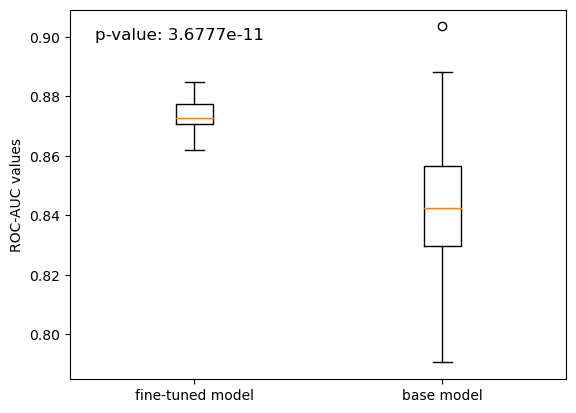

In [113]:
fig, ax = plt.subplots()
boxplot_data = [auc_fine_tuned, auc_base]
ax.boxplot(boxplot_data)
ax.set_xticklabels(['fine-tuned model', 'base model'])
ax.set_ylabel('ROC-AUC values')
ax.text(0.05, 0.95, p_value_text, transform=ax.transAxes, fontsize=12, verticalalignment='top')
plt.savefig('boxplot_comparison.png')
plt.show()


Mean ROC-AUC values of fine-tuned model greater than base model